Кирилл Лалаянц, R33352

# Лабораторная работа No3
## Вынужденное движение

Импорт необходимых для работы библиотек. 

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import math
import scipy

SAVE_PATH = 'tex-report/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)

sympy.init_printing()

def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

## Задание 1. Свободное движение.

In [3]:
p = sympy.Symbol("p")


def task1_output(m1, m2, initial_values, us, ts, plot_name, save_name):
    poly = sympy.simplify((p - m1) * (p - m2))
    coeffs = sympy.Poly(poly, p).all_coeffs()
    # print(f'Polynom: {poly} = {poly.expand()}; coeffs = {coeffs}')
    
    ss = control.tf2ss(control.tf(1, np.array(coeffs, dtype=np.float64)))
    ss_reachable = control.canonical_form(ss, form="reachable")[0]
    # print(f"SS: {ss_reachable}")
    
    responses = {}
    for key_u, u in us.items():
        responses[key_u] = []
        for initial_value in initial_values:
            response = control.forced_response(ss_reachable, U=u(ts), X0=initial_value, T=ts)
            responses[key_u].append((initial_value, response))
    
    plot_task1(responses, ts, plot_name, save_name)
    

def plot_task1(responses, ts, plot_name, save_name):
    f_size = 40
    fig, axs = plt.subplots(1, 3, figsize=(35, 15))
    fig.suptitle(f"Задание 1. Вынужденное движение. \n {plot_name}", fontsize=f_size, y=1)

    for indx, u_key in enumerate(responses):
        u_responses = responses[u_key]
        for initial_value, response in u_responses:
            axs[indx].plot(ts, response.outputs, linewidth=8, label =f'$y(0) = {initial_value[1]}$; ' + "$\dot{y}(0) = $" + f"{initial_value[0]}")
        axs[indx].set_title(u_key, fontsize=f_size)
        axs[indx].set_xlabel(f"t, [c]", fontsize=f_size)
        axs[indx].set_ylabel(f"y, [м]", fontsize=f_size)
        axs[indx].grid(True)
        axs[indx].legend(fontsize=f_size-8, title_fontsize=f_size, title="Начальные условия")
        axs[indx].tick_params(axis='both', labelsize=20)
            
    plt.savefig(f'{SAVE_PATH}/{save_name}')
    plt.show()
    

In [4]:
us = {
    'u(t) = 1.5': lambda t: 1.5 + 0 * t,
    'u(t) = 0.6t': lambda t: 0.6 * t,
    'u(t) = sin(6t)': lambda t: np.sin(6 * t),
}

1. две устойчивые апериодические модам;

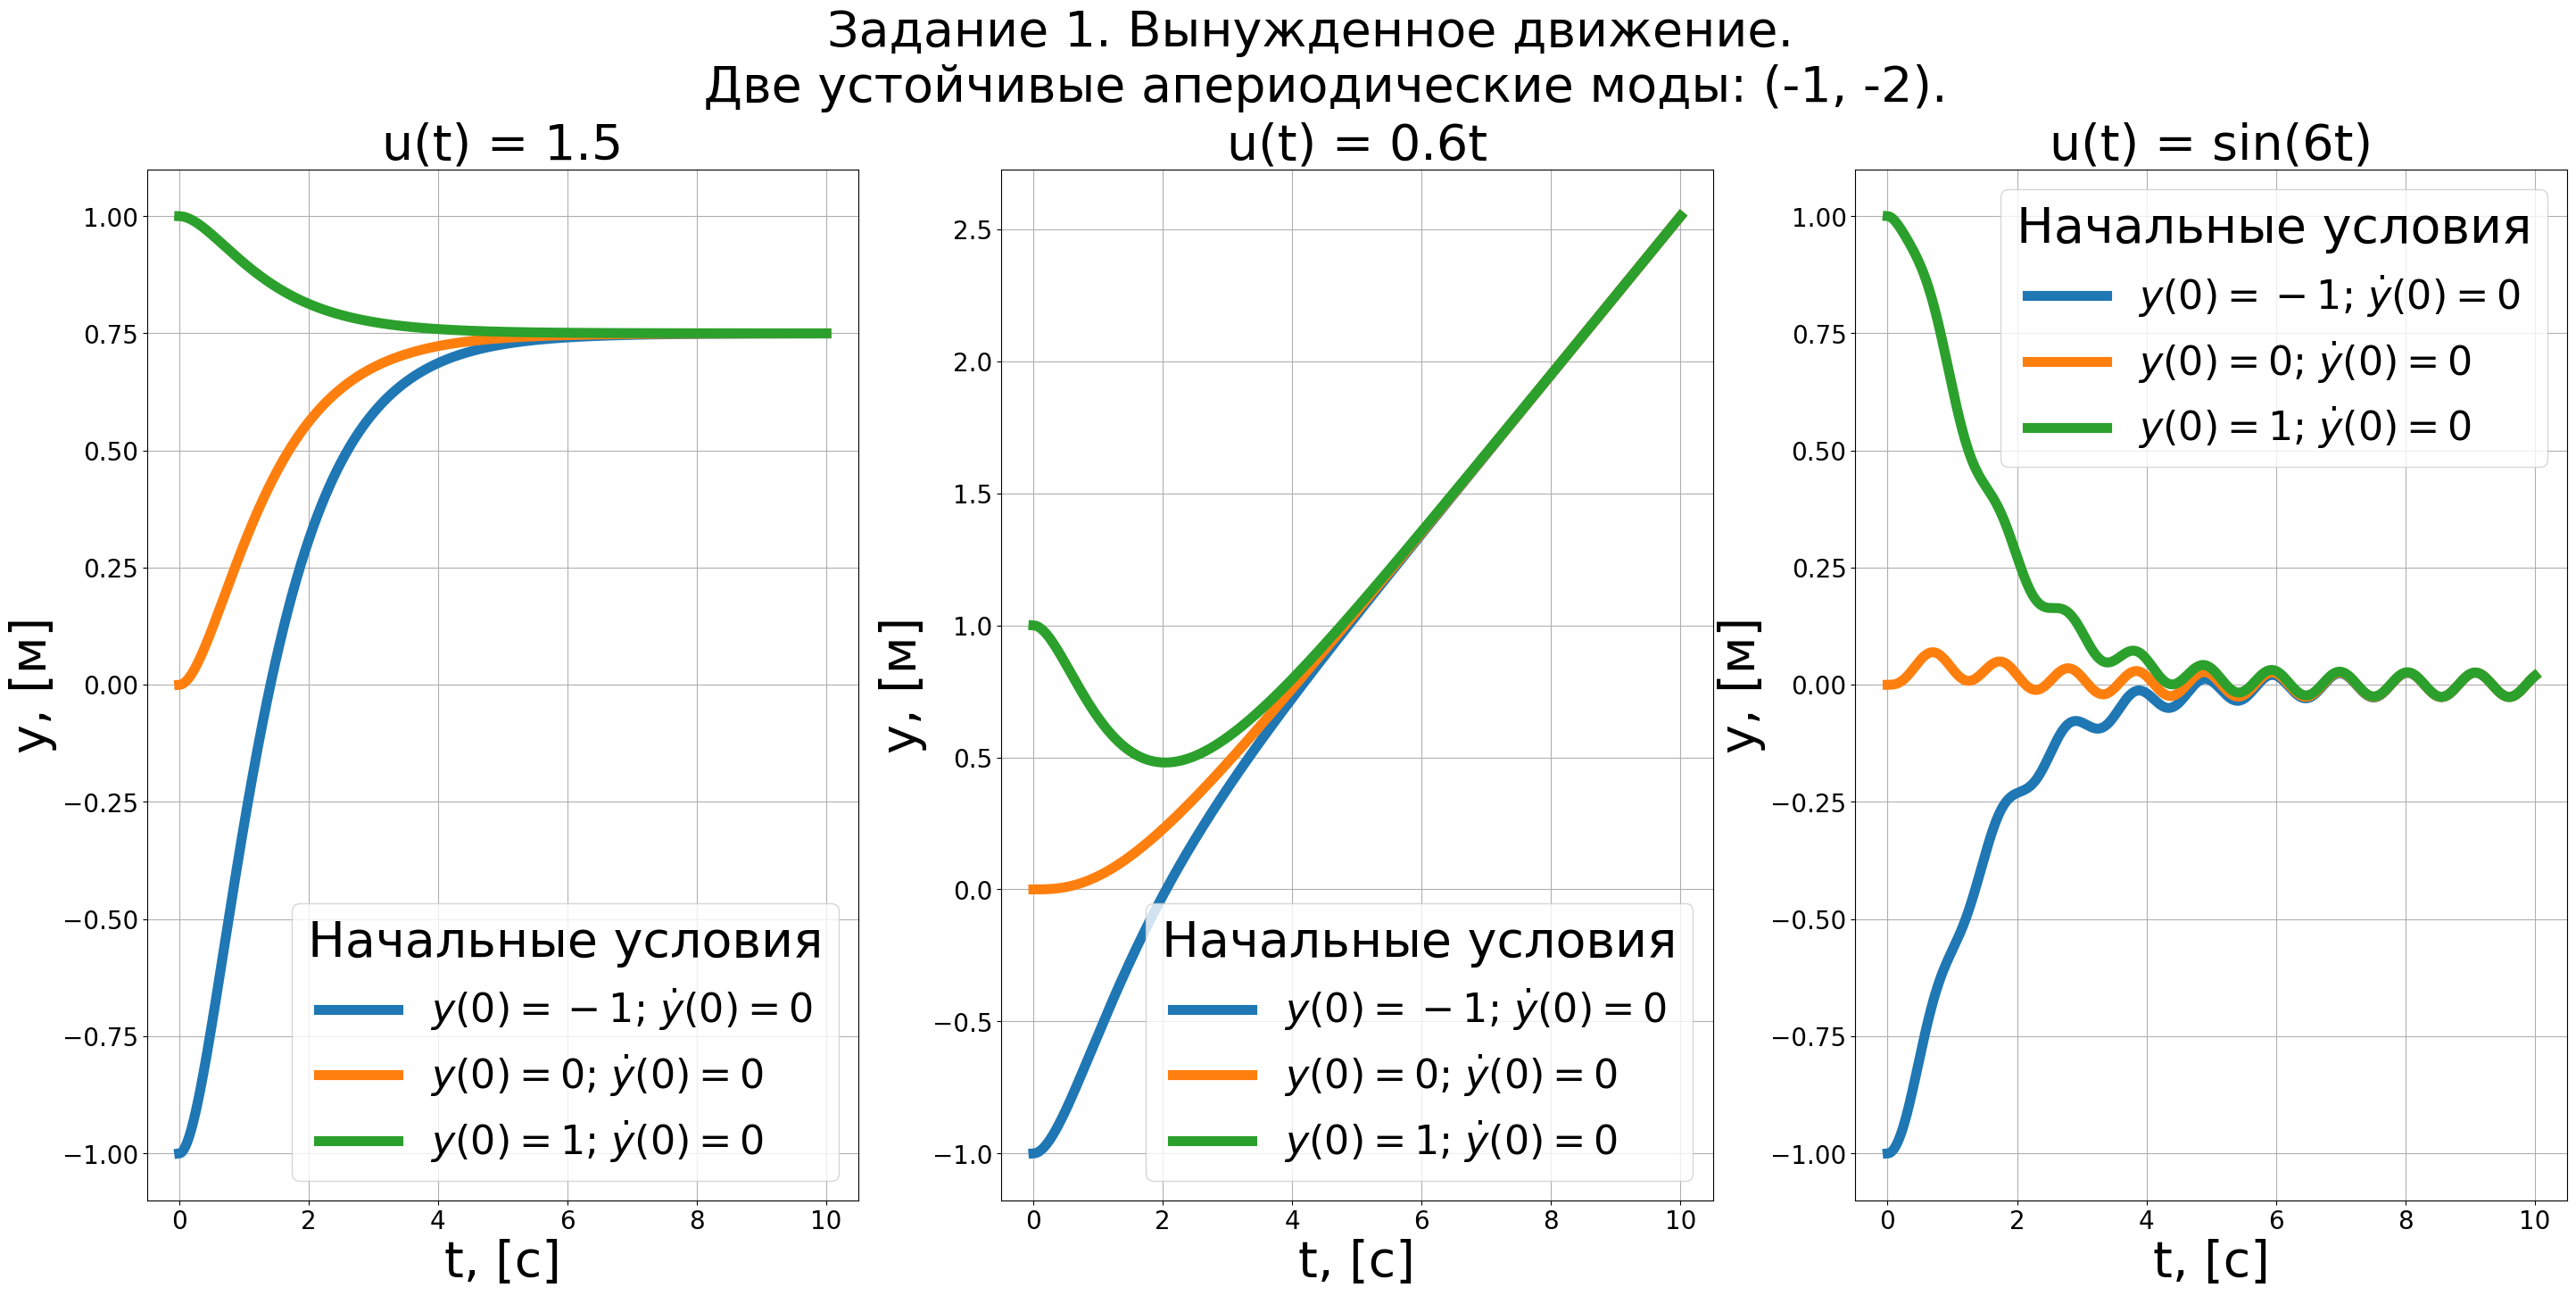

In [5]:
m10, m11 = -1, -2
initial_values = [[0, -1], [0, 0], [0, 1]]
task1_output(m10, m11, initial_values, us, get_t(10), plot_name = f'Две устойчивые апериодические моды: {m10, m11}.', save_name = 'task1_1.jpg')

3. нейтральной и устойчивой апериодическим модам;

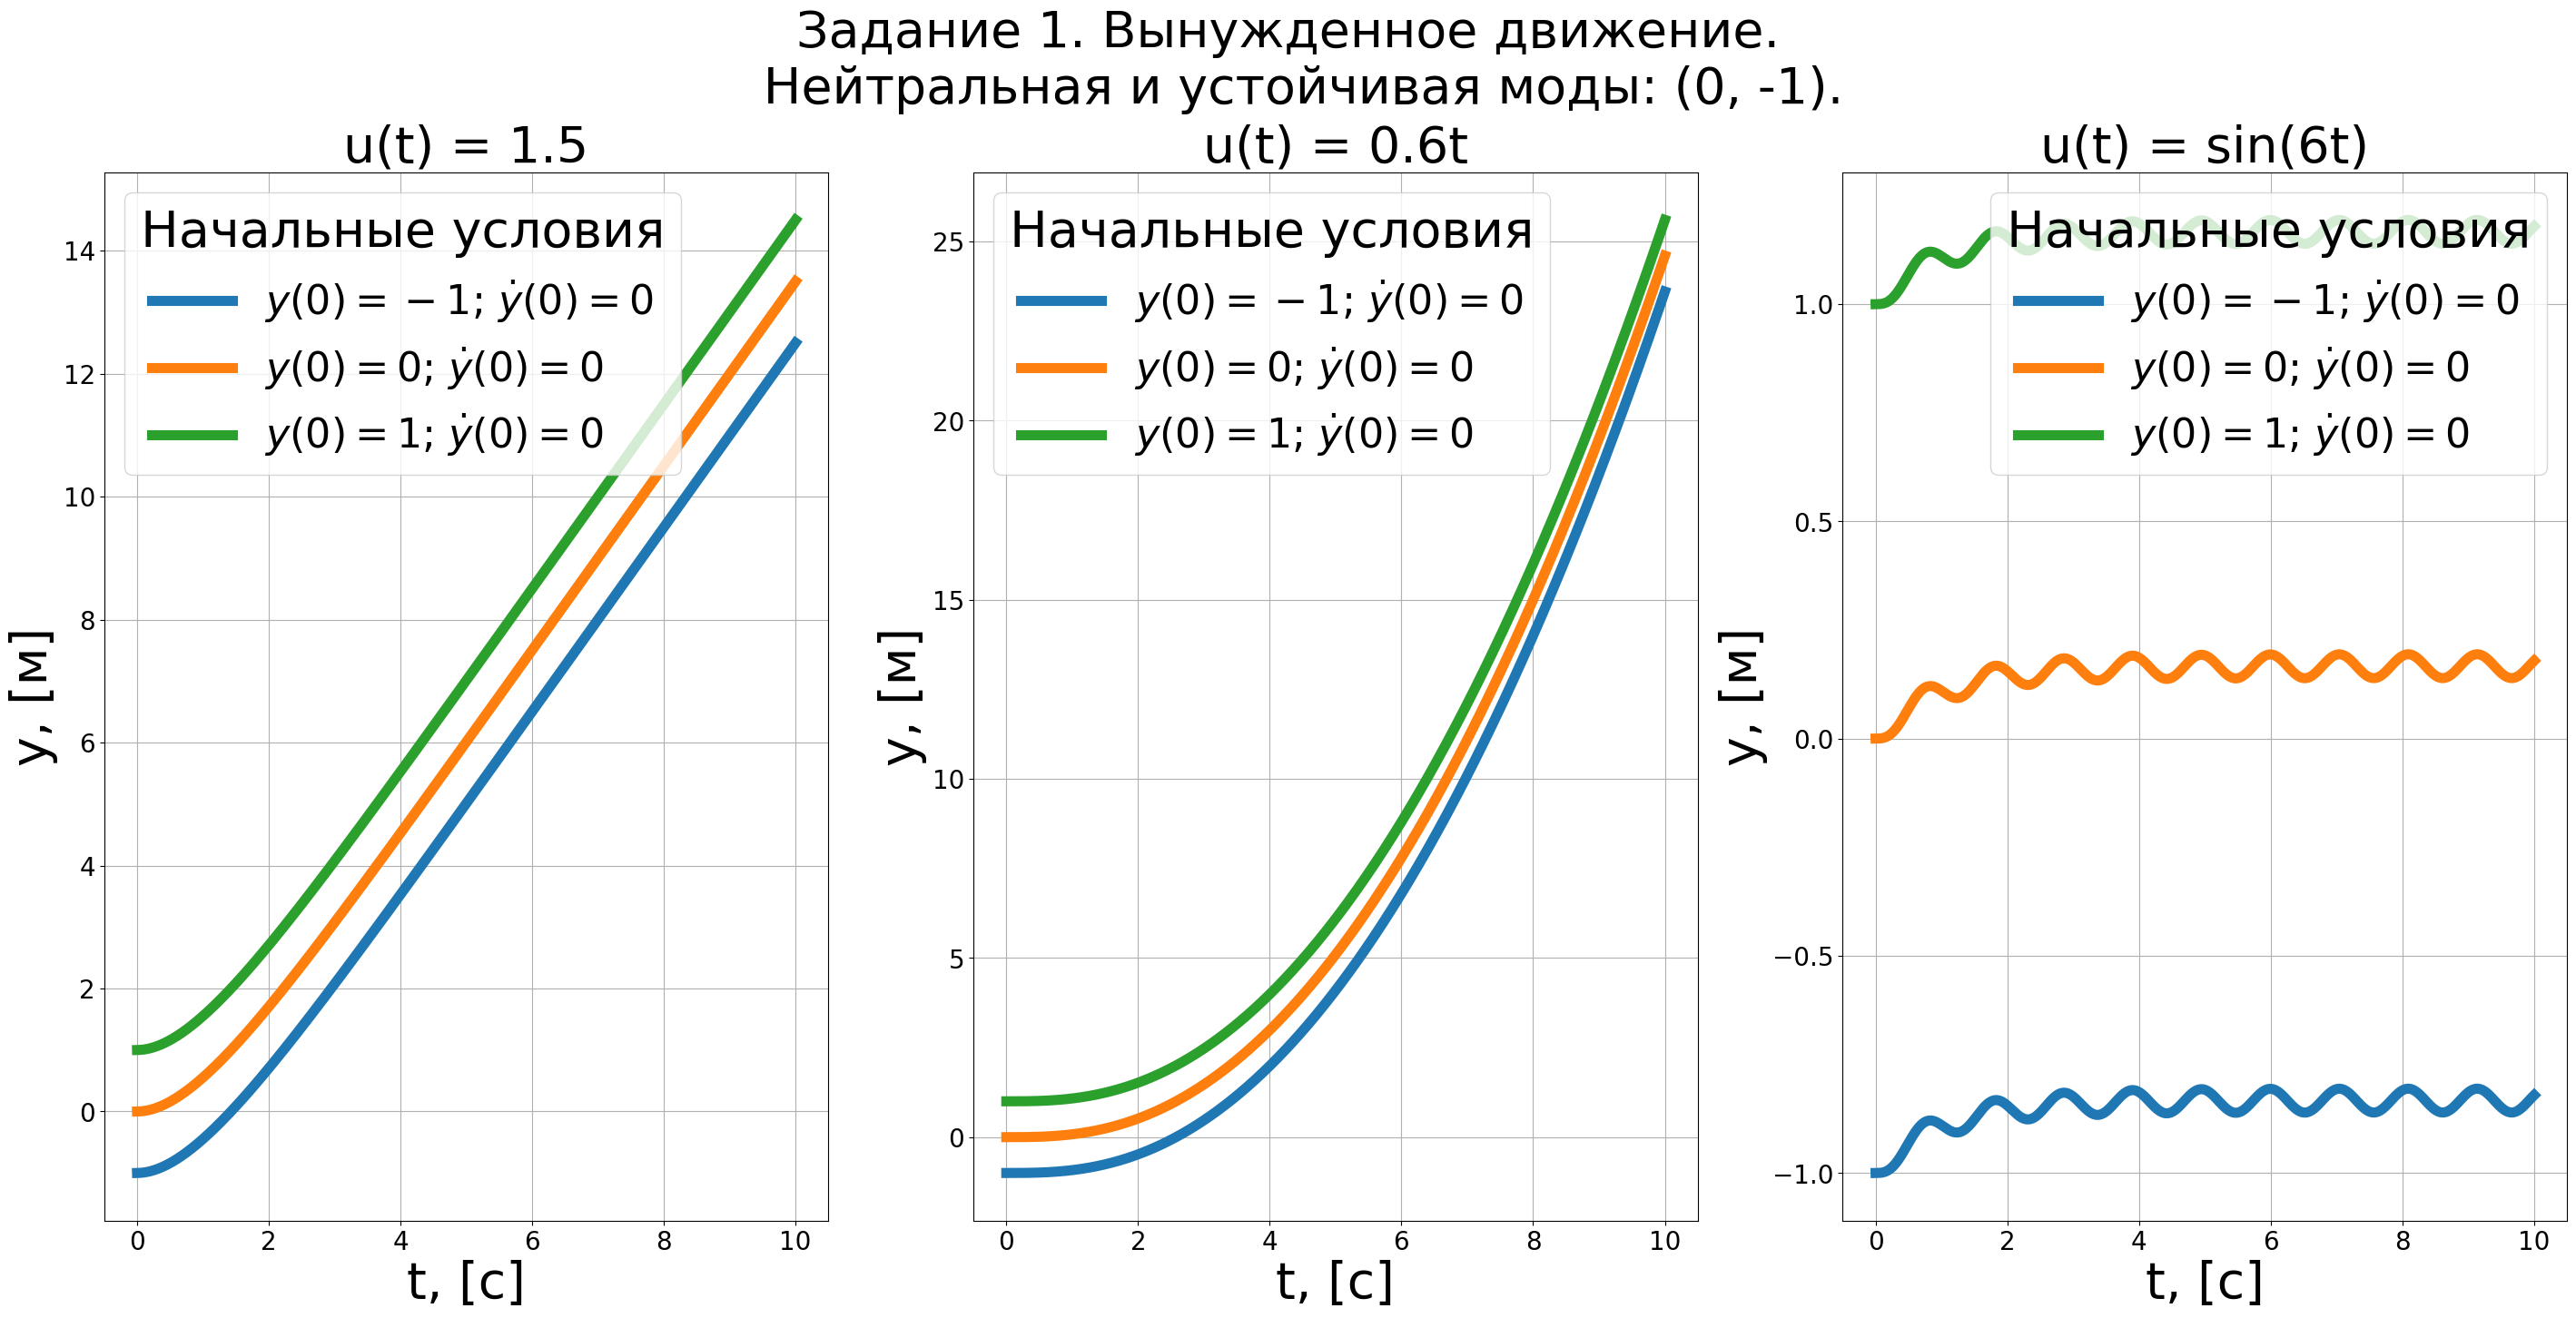

In [6]:
m30, m31 = 0, -1
initial_values = [[0, -1], [0, 0], [0, 1]]
task1_output(m30, m31, initial_values, us, get_t(10), plot_name = f'Нейтральная и устойчивая моды: {m30, m31}.', save_name = 'task1_3.jpg')

6. паре неустойчивых колебательных мод.

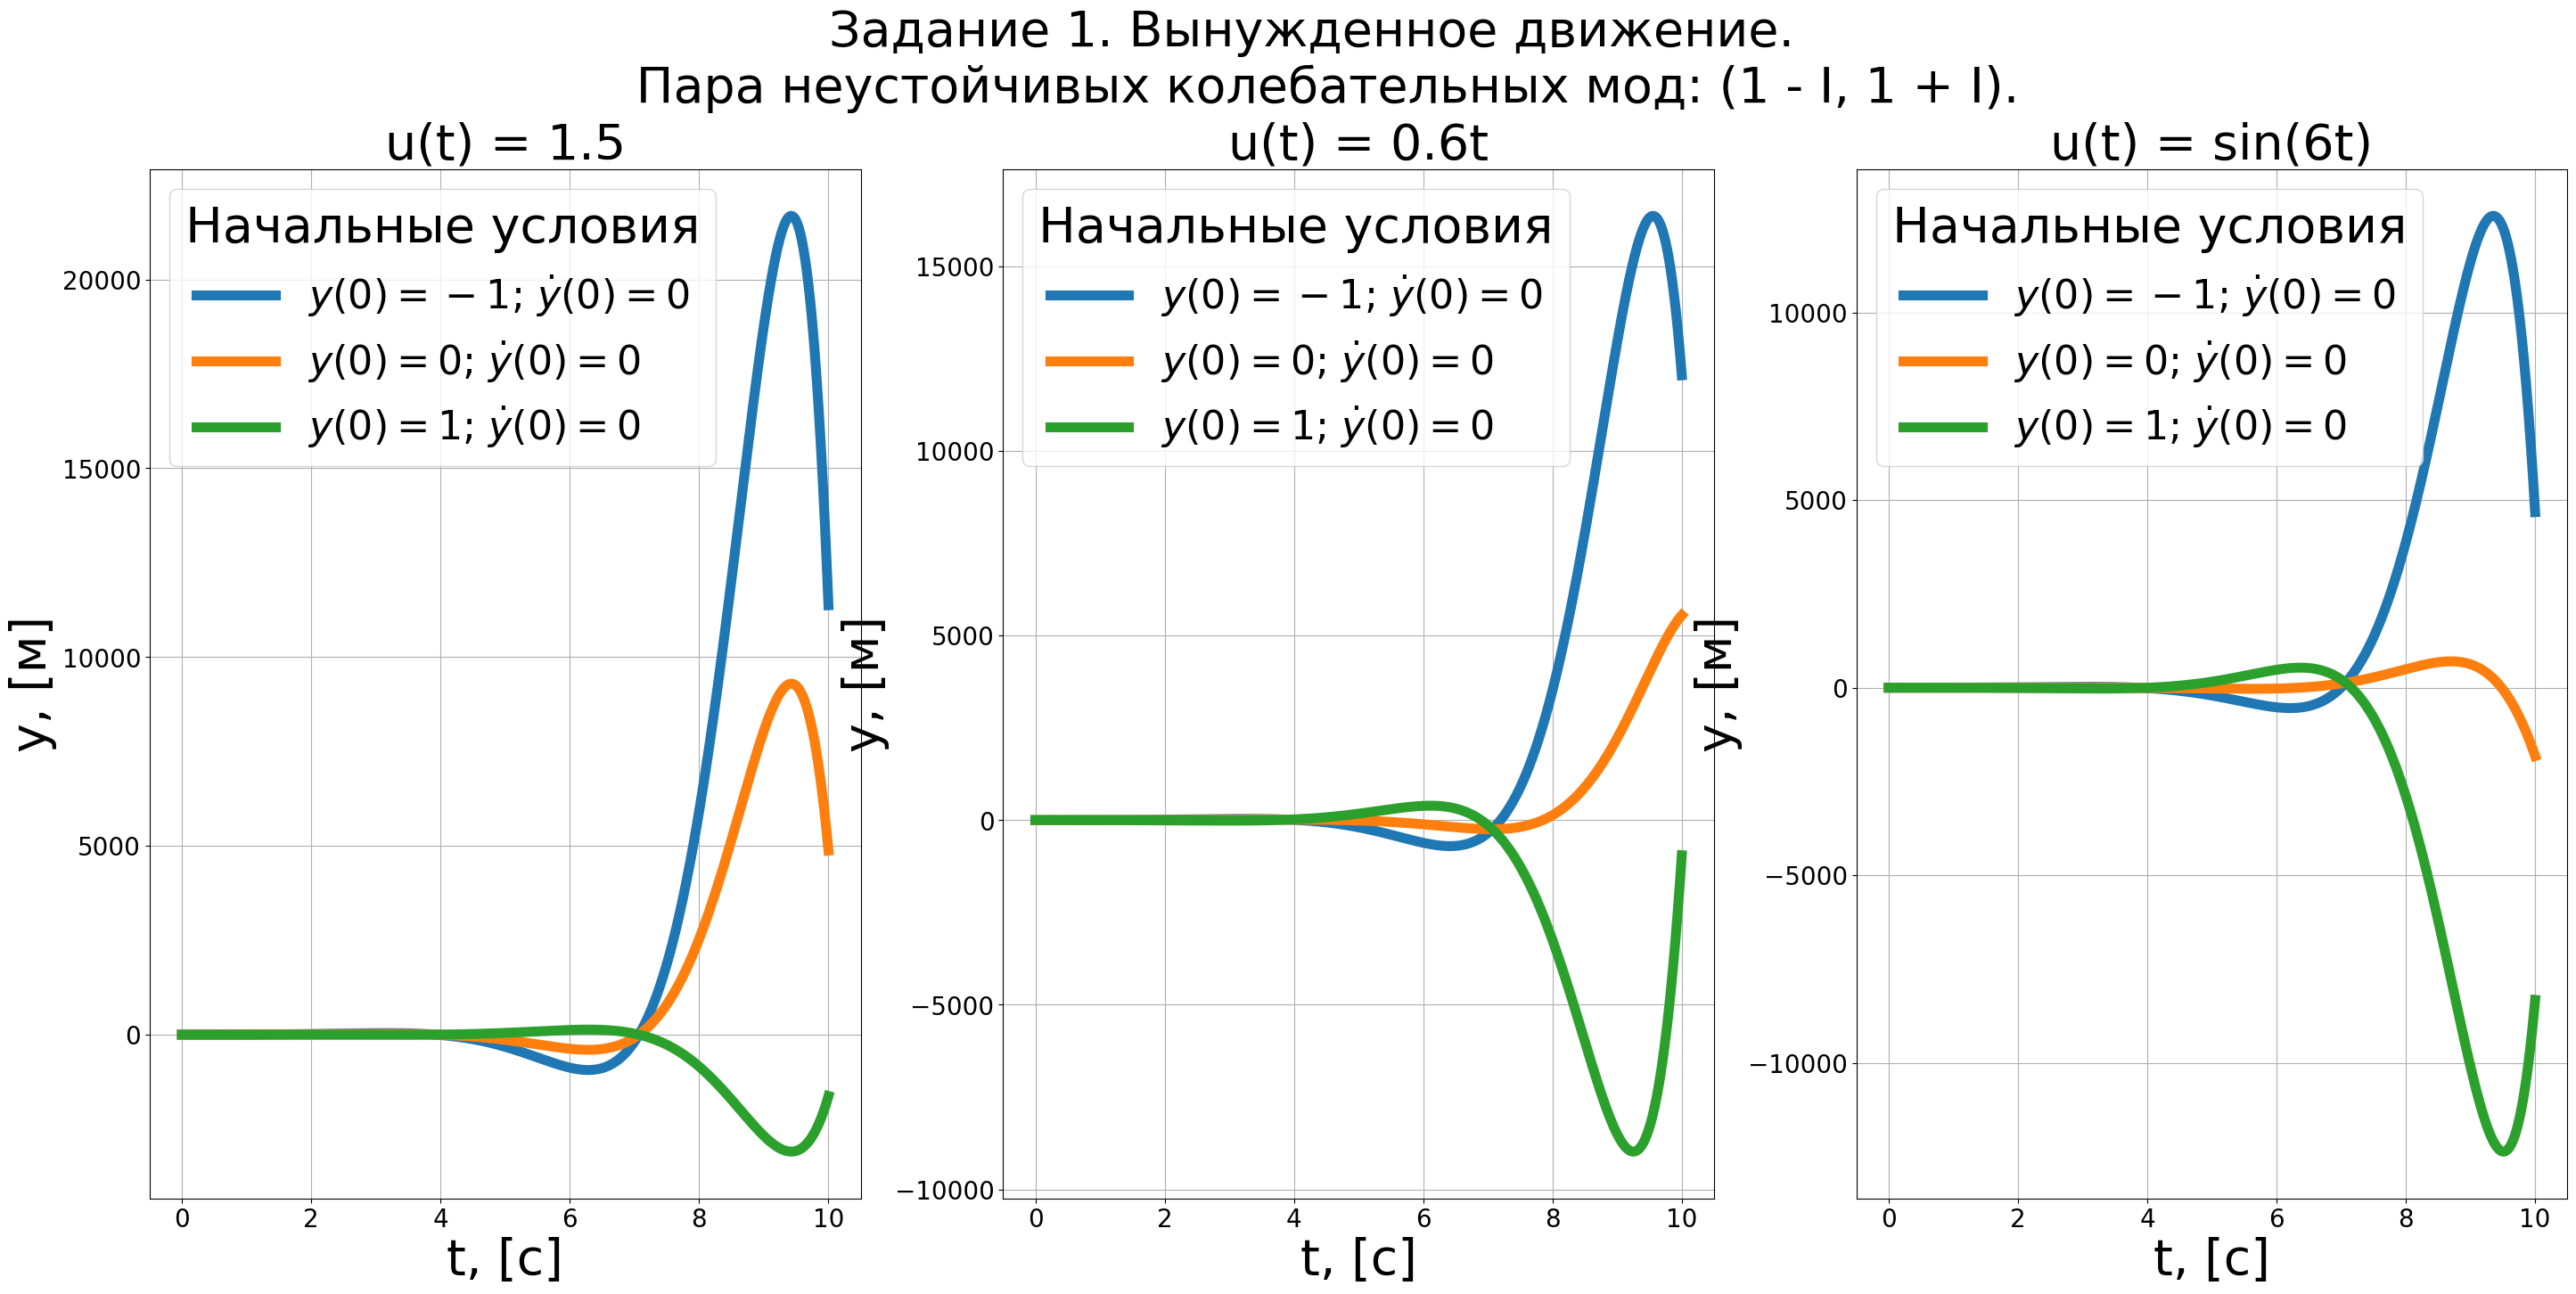

In [7]:
m80, m81 = 1 - sympy.I, 1 + sympy.I
initial_values = [[0, -1], [0, 0], [0, 1]]
task1_output(m80, m81, initial_values, us, get_t(10), plot_name = f'Пара неустойчивых колебательных мод: {m80, m81}.', save_name = 'task1_8.jpg')

## Задание 2. Область устойчивости.

In [512]:
y = sympy.Function("y")
t = sympy.Symbol("t")

def get_ss_reachable(modes):
    poly = 1
    for mode in modes:
        poly = sympy.simplify(poly * (p - mode))
    coeffs = sympy.Poly(poly, p).all_coeffs()
    
    ss = control.tf2ss(control.tf(1, np.array(coeffs, dtype=np.float64)))
    ss_reachable = control.canonical_form(ss, form="reachable")[0]
    return ss_reachable


def get_state_limit(ss_reachable, T0, initial_values_T0):
    params = np.concatenate((ss_reachable.A[0, :], ss_reachable.B[0, :]))
    a2, a1, a0, b0 = map(float, -params)
    b0 = -b0
    
    ics={y(T0): initial_values_T0[0], y(t).diff(t, 1).subs(t, T0): initial_values_T0[1], y(t).diff(t, 2).subs(t, T0): initial_values_T0[2]}
    ode_sympy = sympy.dsolve(y(t).diff(t, 3) + a2 * y(t).diff(t, 2) + a1 * y(t).diff(t, 1) + a0*y(t) - 1, X0=0, ics=ics)
    time_of_limit = 10**10
    state_limit = ode_sympy.subs(t, time_of_limit).rhs
    while abs(1 - state_limit/ode_sympy.subs(t, time_of_limit * 10).rhs) > 0.001:
        time_of_limit *= 10
        state_limit = ode_sympy.subs(t, time_of_limit).rhs
    return state_limit

def model_until_5percent_band(ss_reachable, initial_values, state_limit):
    percent5_interval = state_limit * 0.05
    t_max = 10
    while True:
        ts = get_t(t_max)
        response = control.forced_response(ss_reachable, U=1, X0=initial_values[::-1], T=ts)

        t_5_percent = 0
        for i in range(len(ts)):
            if abs(response.outputs[i] - state_limit) > percent5_interval:
                t_5_percent = ts[i]
                t_5_percent_i = i
                y_5_percent = response.outputs[i]
        if t_5_percent <= t_max*0.8:
            ts = get_t(t_max)
            response = control.forced_response(ss_reachable, U=1, X0=initial_values[::-1], T=ts)
            
            return (ts, response.outputs, t_5_percent, y_5_percent, t_5_percent_i * 2)
        t_max *= 1.5
    
def get_overshooting(response_outputs, ts, state_limit):
    overshooting_values = response_outputs - state_limit
    if overshooting_values[0] > 0:
        overshooting_values *= -1
    overshooting_counter = 0
    while overshooting_values[overshooting_counter] < overshooting_values[overshooting_counter + 1]:
        overshooting_counter += 1
        if overshooting_counter >= len(overshooting_values) - 1:
            break
    
    absolute_overshooting = overshooting_values[overshooting_counter]
    relative_overshooting = overshooting_values[overshooting_counter] / state_limit
    y_overshooting = response_outputs[overshooting_counter]
    t_overshooting = ts[overshooting_counter]
    return (t_overshooting, y_overshooting, relative_overshooting, absolute_overshooting)
    
    

def task2_analyse(modes, T0 = 0, initial_values_T0 = [0, 0, 0]):
    results = {}
    for title, mode in modes.items():
        ss_reachable = get_ss_reachable(mode)
        ss_limit = get_state_limit(ss_reachable, T0, initial_values_T0)
        ts, ss_y, t_5p, y_5p, _ = model_until_5percent_band(ss_reachable, initial_values, ss_limit)
        t_os, y_os, os_rel, _ = get_overshooting(ss_y, ts, ss_limit)
        results[title] = [mode, ts, ss_y, ss_limit, t_5p, y_5p, t_os, y_os, os_rel]
    return results

    
    
def plot_task2(results, plot_name, save_name=None, f_size = 40, lf_size = 20):
    fig, axs = plt.subplots(2, 3, figsize=(35, 15))
    fig.suptitle(f'Задание 2. Качество переходных процессов. \n {plot_name}', fontsize=f_size, y=1)
    for i, result in results.items():
        mode, ts, ss_y, ss_limit, t_5p, y_5p, t_os, y_os, os_rel = result
        if os_rel < 0.05:
            y_os = float(ss_limit)
        t_max = ts[-1]
        axs[0][i].set_title(f"$T_{'{пер}'} = {t_5p: .1e}; \Delta\sigma = {os_rel: .1e}$", fontsize=f_size - 10)
        axs[0][i].plot(ts, ss_y, 'b--', label = 'TF')
        axs[0][i].set_xticks([0, t_max, t_5p], [0, f'{t_max : 0.2f}', f'{t_5p : 0.2f}'], fontsize=lf_size)
        axs[0][i].set_yticks([0, y_os, float(ss_limit)],[0, f'{y_os : 0.2f}', f'{ss_limit : 0.2f}'], fontsize=lf_size)
        axs[0][i].legend(fontsize=lf_size)
        axs[0][i].grid()
        
        re_modes = list(map(float, map(sympy.re, mode)))
        im_modes = list(map(float, map(sympy.im, mode)))
        axs[1][i].scatter(re_modes, im_modes, linewidths=10)
        axs[1][i].set_yticks(im_modes, im_modes, fontsize=lf_size)
        axs[1][i].set_xticks(re_modes, re_modes, fontsize=lf_size)
        axs[1][i].set_xlabel("Re", fontsize=f_size)
        axs[1][i].set_ylabel("Im", fontsize=f_size)
        axs[1][i].grid()
    
    if save_name:
        plt.savefig(f'{SAVE_PATH}/{save_name}')
        

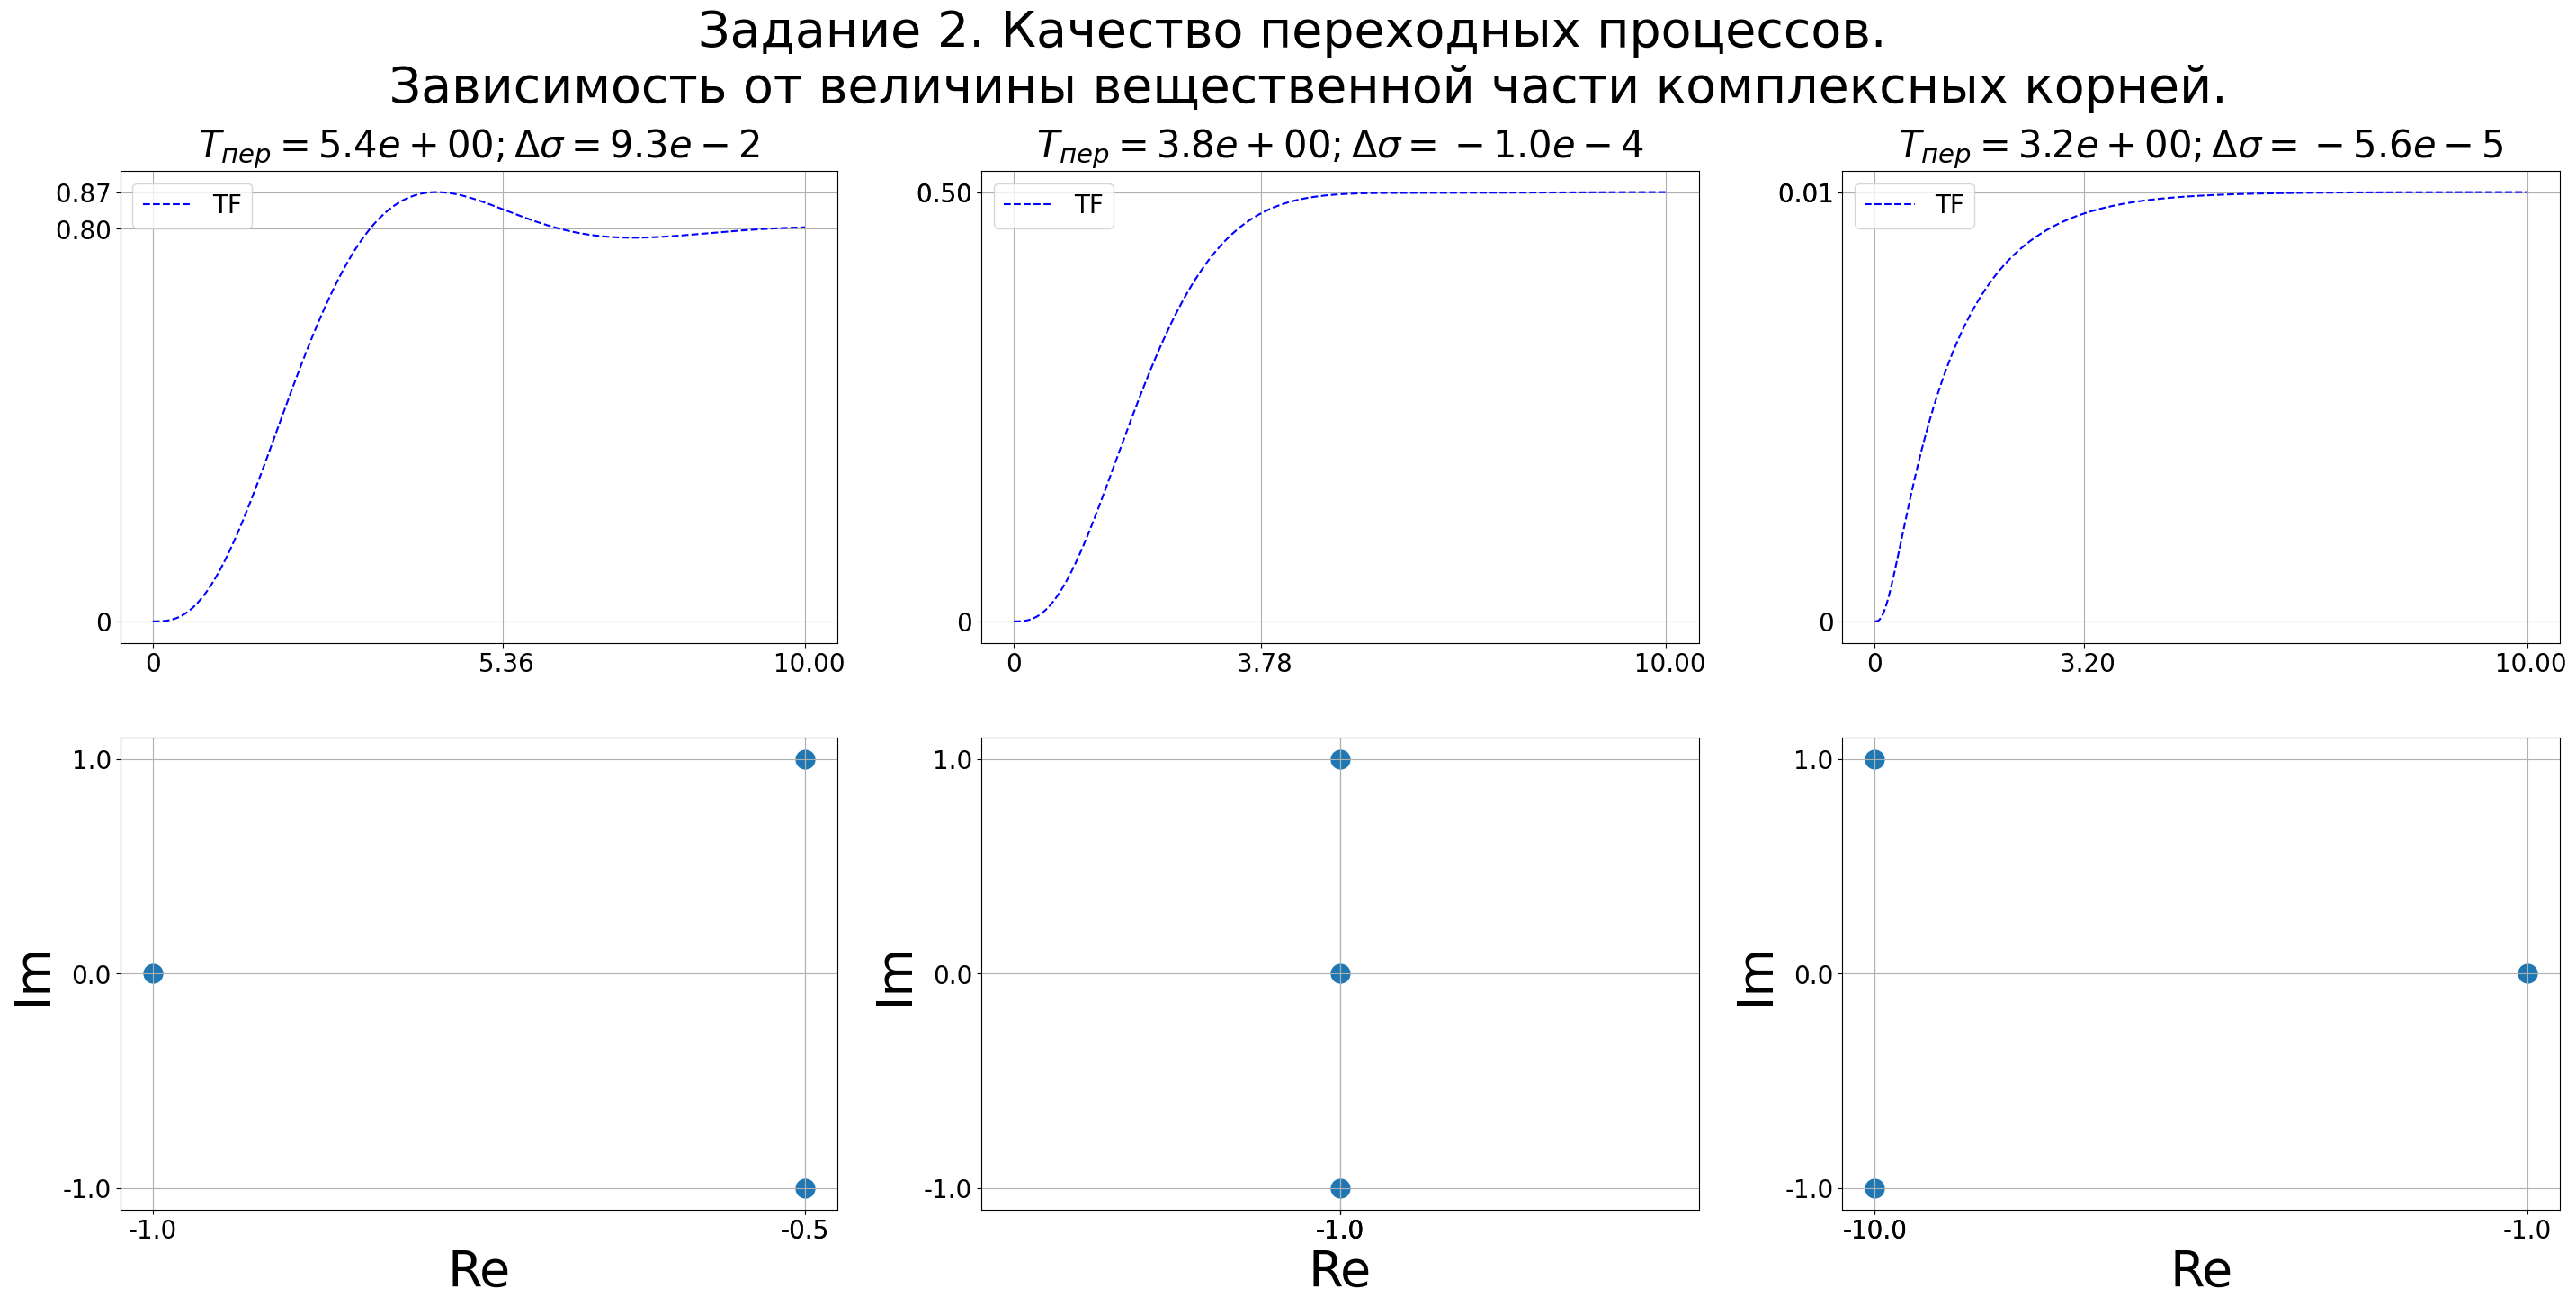

In [519]:
modes_1 = {
    0: [-1, -0.5 + 1 * sympy.I, - 0.5 - 1 * sympy.I],
    1: [-1, -1 + 1 * sympy.I, - 1 - 1 * sympy.I],
    2: [-1, -10 + 1 * sympy.I, - 10 - 1 * sympy.I],
}

# results_1 = task2_analyse(modes_1)
plot_task2(results_1, 'Зависимость от величины вещественной части комплексных корней.', save_name='task2_diff_I.jpg')

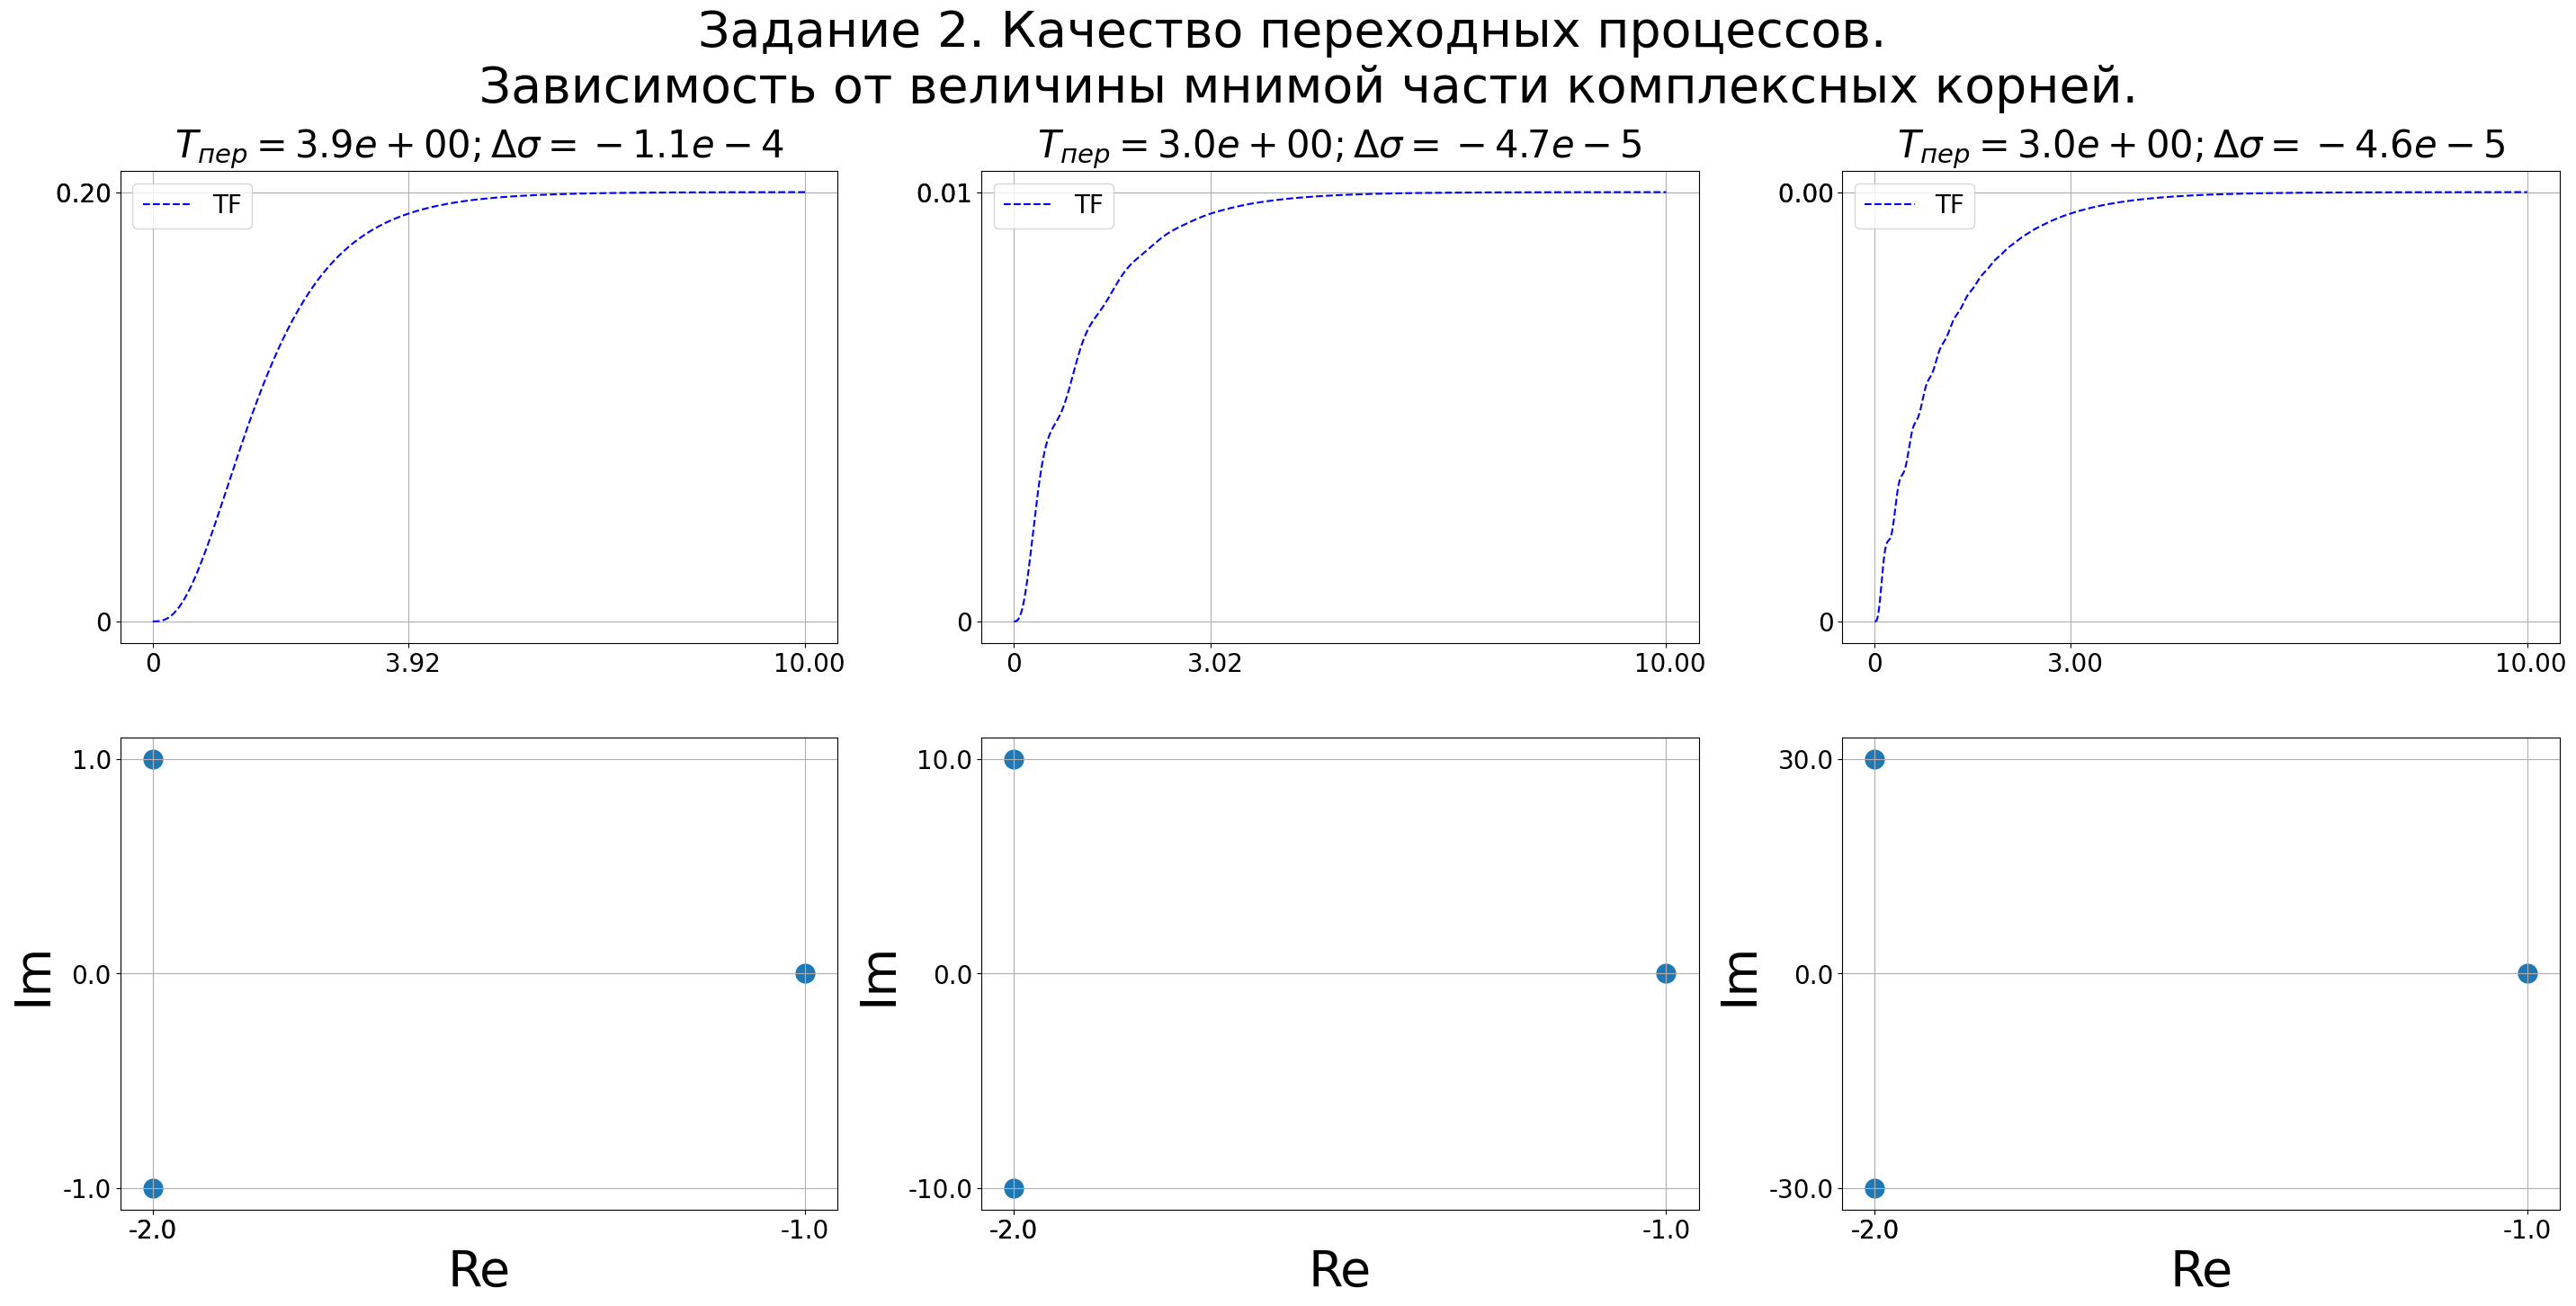

In [520]:
modes_2 = {
    0: [-1, -2 + 1 * sympy.I, -2 - 1 * sympy.I],
    1: [-1, -2 + 10 * sympy.I, -2 - 10 * sympy.I],
    2: [-1, -2 + 30 * sympy.I, -2 - 30 * sympy.I],
}

# results_2 = task2_analyse(modes_2)
plot_task2(results_2, 'Зависимость от величины мнимой части комплексных корней.', save_name='task2_diff_real_with_I.jpg')

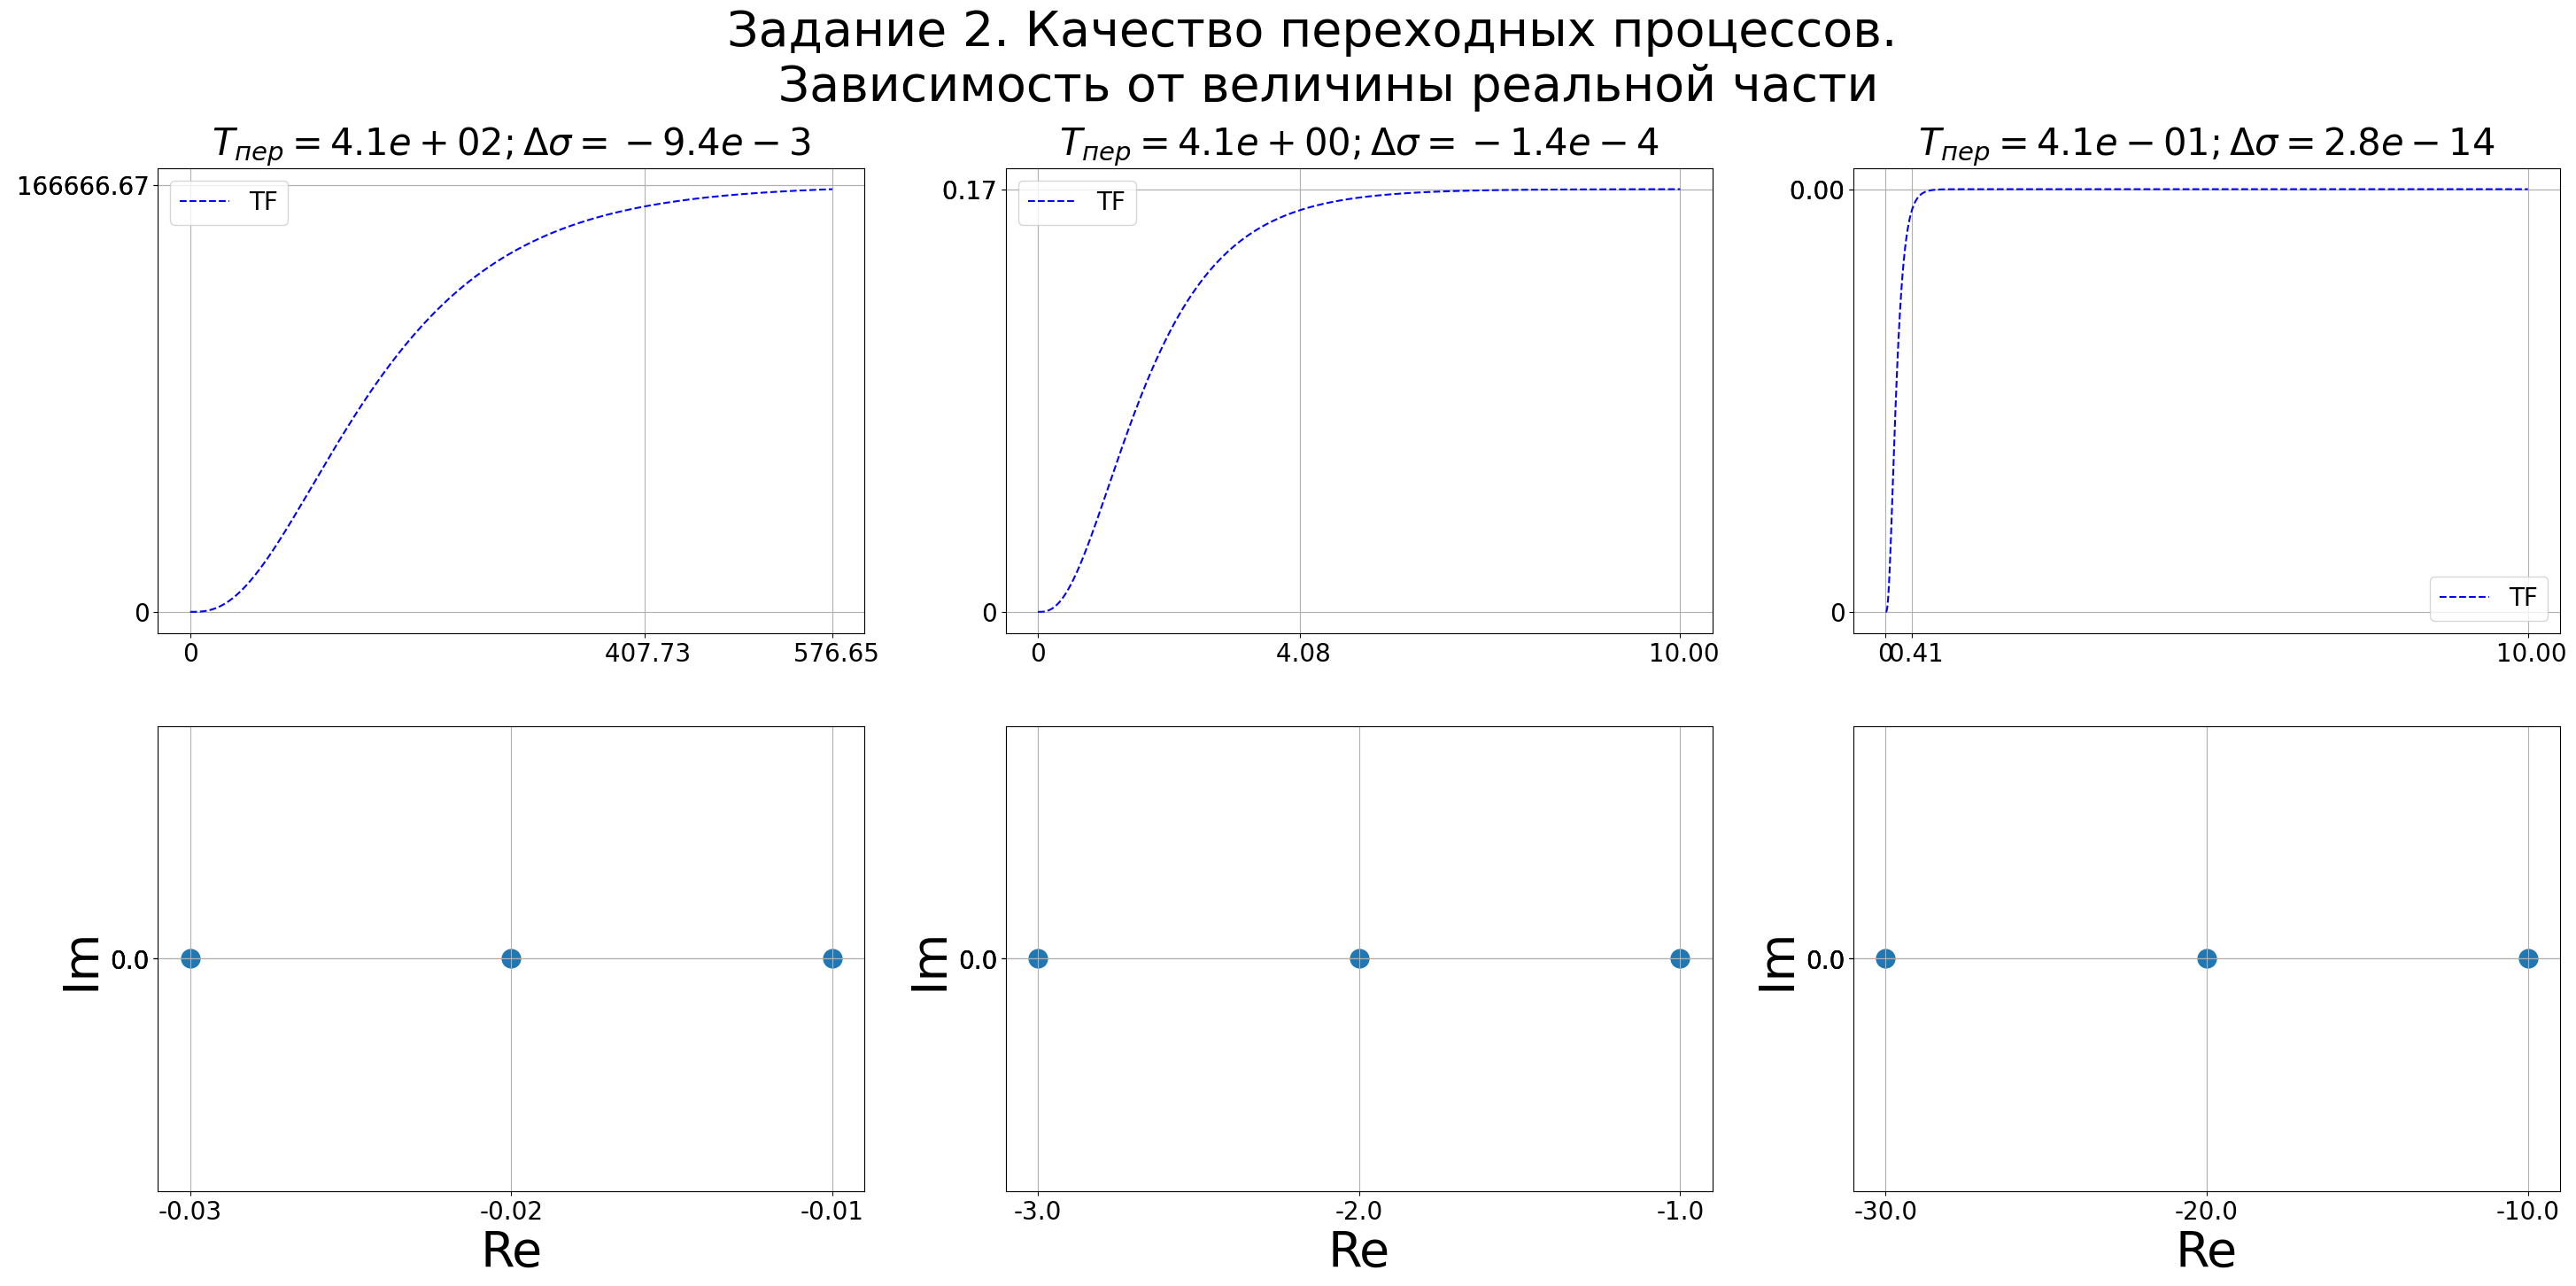

In [521]:
modes_3 = {
    0: [-0.01, -0.02, - 0.03],
    1: [-1, -2, -3],
    2: [-10, -20, -30],
}

# results_3 = task2_analyse(modes_3)
plot_task2(results_3, 'Зависимость от величины реальной части', save_name='task2_diff_real_no_I.jpg')